<a href="https://colab.research.google.com/github/GVSU-CIS635/projects-outliers/blob/SARIMA-Building/Arima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
%matplotlib inline
from matplotlib.pylab import rcParams

In [2]:
# Set the default figure size for matplotlib plots to 15 inches wide by 6 inches tall
rcParams["figure.figsize"] = (15, 6)

# Increase the default font size of the titles in matplotlib plots to extra-extra-large
rcParams["axes.titlesize"] = "xx-large"

# Make the titles of axes in matplotlib plots bold for better visibility
rcParams["axes.titleweight"] = "bold"

# Set the default location of the legend in matplotlib plots to the upper left corner
rcParams["legend.loc"] = "upper left"

# Configure pandas to display all columns of a DataFrame when printed to the console
pd.set_option('display.max_columns', None)

# Configure pandas to display all rows of a DataFrame when printed to the console
pd.set_option('display.max_rows', None)

In [20]:
#import dataset
url = "streamflow_filled_ARIMA.csv"
data = pd.read_csv(url)

In [21]:
#split dataset to have a smaller dataset for model testing
dftrain = data[data['Year'] < 2016]
dftest = data[data['Year'] >= 2016]

In [23]:
#importing seasonal ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [24]:
#prepping data for model
dftest['Date'] = pd.to_datetime(dftest['Date'])
dftest = dftest.set_index('Date')
series = dftest['Q (m3/s)']
series = series.asfreq('D')

/tmp/ipython-input-763370984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftest['Date'] = pd.to_datetime(dftest['Date'])


In [25]:
from statsmodels.tsa.stattools import adfuller
#checking if model is stationary
result = adfuller(series.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.1496854938313774
p-value: 0.22501049552883273


model isn't stationary, model values need to change

In [16]:
#inital model tested, model values were insufficent and will need to be changed.
model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


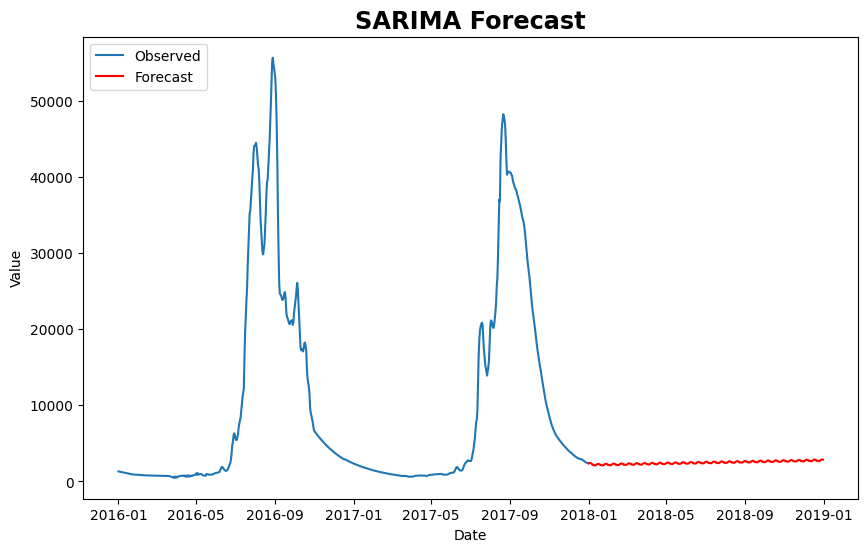

In [29]:
forecast = model_fit.forecast(steps=365)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(series, label='Observed')
plt.plot(forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
#modeling the data but poor future forcasting, edit the model.